## NN in Pytorch
Defining different metrics that define a [candle stick](https://stock-market-forecast.blogspot.com/2012/02/automated-recognition-of-candlestick.html).  

In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plot
import time
import math
import quandl
import matplotlib.pyplot as plot
import numpy as np
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data

In [128]:
stock_val=quandl.get("BCHARTS/BITFINEXUSD")
RB = 100.0 * (stock_val.Close - stock_val.Open) / (stock_val.Open)
US = 100.0 * (stock_val.Close - stock_val.Open) / (stock_val.High - stock_val.Open)
LS = 100.0 * (stock_val.Close - stock_val.Open) / (stock_val.Close - stock_val.Low)
data = torch.zeros((RB.size,3))
data[:,0] = torch.from_numpy(RB.values)
data[:,1] = torch.from_numpy(US.values)
data[:,2] = torch.from_numpy(LS.values)
inputdata = torch.Tensor(data)

In [133]:
stock_val = (stock_val.Close.values - min(stock_val.Close.values))/(max(stock_val.Close.values) - min(stock_val.Close.values))

In [167]:
param = {
    'q': "AAPL", # Stock symbol (ex: "AAPL")
    'i': "86400", # Interval size in seconds ("86400" = 1 day intervals)
    'x': "NASD", # Stock exchange symbol on which stock is traded (ex: "NASD")
    'p': "5Y" # Period (Ex: "1Y" = 1 year)
}
stock_test = get_price_data(param)
stock_test = (stock_test.Close.values - min(stock_test.Close.values))/(max(stock_test.Close.values) - min(stock_test.Close.values))

Define a Neurual Network model with 3 input features, 2 hidden layers and one output layer.![alt text](https://ml4a.github.io/images/figures/neural-net.png)


In [168]:
D_in, H, D_out = 3, 2, 1

In [169]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

Define RNN module with 10 previous outputs to get the next output. RNN module ![alt text](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

In [170]:
input_size, hidden_size, output_size = 10, 128, 1
price_on = 1

In [171]:
def getInputTensor(x, index, input_size):
    inputTensor = x[0, index:(index+input_size)].unsqueeze(0)
    return inputTensor

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input.unsqueeze(0), hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
#         output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1,self.hidden_size))

Combine Two Layer NN and RNN togther for learning

In [172]:
rnn = RNN(input_size, hidden_size, output_size)
learning_rate = 0.0005
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(), learning_rate)
if price_on:
    x = Variable(torch.Tensor(stock_val)).unsqueeze(0)
    y = Variable(torch.Tensor(stock_val[15:len(stock_val)])).unsqueeze(0)
    test_x = Variable(torch.Tensor(stock_test)).unsqueeze(0)
else:
    x = Variable(torch.Tensor(RB.values)).unsqueeze(0)
    y = Variable(torch.Tensor(RB[11:len(RB.values)].values)).unsqueeze(0)


In [173]:

def train(input_tensor, output_tensor):
	hidden = rnn.initHidden()


	loss = 0

	for i in range(input_tensor.size()[0]):
		output, hidden = rnn.forward(input_tensor[i], hidden)
		loss += criterion(output, output_tensor[i])
		optimizer.zero_grad()

	loss.backward()
	optimizer.step()
	return output, loss.data[0] / input_tensor.size()[0]

def test(input_test):
	hidden = rnn.initHidden()
	for i in range(input_test.size()[0]):
		output, hidden = rnn.forward(input_test[i], hidden)

	return output

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [174]:

epoch = 1
n_iters = 1000
print_every = 100
plot_every = 10
all_losses = []
total_loss = 0 # Reset every plot_every iters
o = []
start = time.time()
for j in range(0,epoch):
    for iter in range(0, n_iters + 1):
        output, loss = train(getInputTensor(x, iter, input_size), y[0, iter].unsqueeze(0))
#         output, loss = train(x[0, (iter):(iter+10)].unsqueeze(0), y[0, iter].unsqueeze(0))
#         output, loss = train(x,y)
        total_loss += loss

        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

        if iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0

0m 0s (0 0%) 0.0038
0m 0s (100 10%) 0.0000
0m 0s (200 20%) 0.0019
0m 0s (300 30%) 0.0072
0m 0s (400 40%) 0.0020
0m 0s (500 50%) 0.0000
0m 0s (600 60%) 0.0000
0m 0s (700 70%) 0.0001
0m 0s (800 80%) 0.0000
0m 0s (900 90%) 0.0000
0m 0s (1000 100%) 0.0005


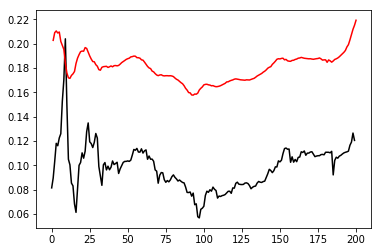

In [175]:
d = 200
o=[]
for iter in range(0, d):
	output = test(x[0, (iter):(iter + 10)].unsqueeze(0))
	o.append(float(output))



plot.figure(1)
if price_on:
    plot.plot(stock_val[0:d], color='black')
else:
    plot.plot(RB[0:d].values, color='black')
# plot.plot(np.arange(1,1001), o[0:1000], color = 'blue')
# plot.plot(np.arange(1002, d+1), o[1001:d], color = 'red')
plot.plot(np.arange(1, d+1), o, color = 'red')
plot.show()

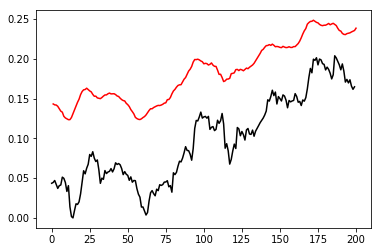

In [177]:
d = 200
o=[]
for iter in range(0, d):
	output = test(test_x[0, (iter):(iter + 10)].unsqueeze(0))
	o.append(float(output))



plot.figure(1)
if price_on:
    plot.plot(stock_test[0:d], color='black')
else:
    plot.plot(RB[0:d].values, color='black')
# plot.plot(np.arange(1,1001), o[0:1000], color = 'blue')
# plot.plot(np.arange(1002, d+1), o[1001:d], color = 'red')
plot.plot(np.arange(1, d+1), o, color = 'red')
plot.show()